# Questions for today

- Time series data acquisition struggles
- Class imbalance: should we find different data?
- How could we rethink the target variable?
- Is 5% too many outliers to remove?

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.spatial import distance

# Reading in Data

In [2]:
#info = pd.read_csv('patient_information.csv')
info = pd.read_csv('/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 527/EMR/patient_information.csv')
info.head()

,PID,Age,Ht,Wt,Gender,OR_start,OR_end,Surgery_start,Surgery_end,Procedure
0,56d1bc3e2a07cc1a,19,160,51,F,1/1/16 7:30,1/1/16 15:25,1/1/16 8:29,1/1/16 15:14,"Funtional rhinoplasty, repair of vestibular st..."
1,411a637540c1d665,51,162,71,F,12/26/16 7:11,12/26/16 8:32,12/26/16 7:50,12/26/16 8:21,"Excision Ganglion Cyst left dorsal hand,splint..."
2,51206705422a4c5c,41,165,58,F,6/19/16 8:15,6/19/16 13:37,6/19/16 8:57,6/19/16 13:37,"Abdominoplasty, Bilateral Flank Liposuction"
3,40750c9577f139bd,55,162,66,F,12/11/15 13:13,12/11/15 20:09,12/11/15 14:07,12/11/15 19:51,"1.Bilateral endoscopic sinus surgery, inferior..."
4,ed4ac97e460b5a79,41,158,76,F,4/18/16 7:11,4/18/16 9:31,4/18/16 8:07,4/18/16 9:31,Left breast: Tissue expander Exchange for Sili...


In [9]:
df_info = pd.read_csv("https://api.vitaldb.net/cases")
df_ids = pd.read_csv("https://api.vitaldb.net/trks")
df_lab = pd.read_csv("https://api.vitaldb.net/labs")

In [22]:
info = df_info[['subjectid', 'age', 'height', 'weight', 'sex', 'opstart', 'opend']].copy()
info

,subjectid,age,height,weight,sex,opstart,opend
0,5955,77.0,160.2,67.50,M,1668,10368
1,2487,54.0,167.3,54.80,M,1721,14621
2,2861,62.0,169.1,69.70,M,1090,3010
3,1903,74.0,160.6,53.00,M,2522,17822
4,4416,66.0,171.0,59.70,M,2591,20291
...,...,...,...,...,...,...,...
6383,5583,64.0,161.5,63.00,M,2140,14140
6384,2278,69.0,159.3,62.30,M,2396,19496
6385,4045,61.0,151.7,43.25,F,3533,18233
6386,5230,24.0,155.7,55.50,F,1730,11030


In [3]:
#events = pd.read_csv('patient_procedure_events.csv')
events = pd.read_csv('/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 527/EMR/patient_procedure_events.csv')
events.head()

,PID,Event_time,Event_name
0,aca232a2eb2d82af,2018-08-13 16:03:00,MD Handoff
1,aca232a2eb2d82af,2018-08-13 17:37:00,Extubation
2,aca232a2eb2d82af,2018-08-13 07:31:00,Intubation
3,27f74474129a0c63,2018-02-14 10:44:00,Extubation
4,27f74474129a0c63,2018-02-14 07:23:00,Intubation


In [4]:
events['Event_name'].unique()

array(['MD Handoff', 'Extubation', 'Intubation', 'LMA', 'Spinal', 'TQ Up',
       'Sedation', 'CPBP On', 'Aortic CC', 'CPBP Off', 'CSE', 'CPR',
       'Mayfield', 'Epidural', 'ANH out', 'ANH In', 'Defib',
       'Circ Arrest'], dtype=object)

### Which events are adverse?
- MD Handoff, Extubation, Intubation: routine, not adverse
- LMA (laryngial mask airways): can be for administration of anesthesia or life saving measure for failed airway (not necessarily adverse) 
- Spinal: too vague, assuming not adverse
- TQ Up: unclear, assuming not adverse
- Sedation: administration of anesthesia, not adverse
- CPBP (cardiopulmonary bypass) On/Off: machine for replacement of heart and lung functions, not necessarily adverse
- Aortic CC: unclear, assuming not adverse
- CSE (combined spinal epidural): combination of spinal and epidural anesthesia, not adverse
- CPR: **adverse**
- Mayfield: can refer to a device or procedure, not adverse
- Epidural: not adverse
- ANH (acute normovolemic hemodilution) Out/In: blood conservation technique, not adverse
- Defib: **adverse**
- Circ Arrest: circulatory arrest, surgical technique to reduce blood loss, not necessarily adverse

In [6]:
adverse_events = events[(events['Event_name']=='Defib') | (events['Event_name']=='CPR')]
print(f'There are {len(adverse_events)} adverse events out of a total {len(events)} events for {len(info)} surgeries')

adverse_events

There are 7 adverse events out of a total 40801 events for 19114 surgeries


,PID,Event_time,Event_name
1990,6d3adae9f7e386c6,2017-07-04 20:01:00,CPR
19521,aa028abbb7d98a45,2017-04-14 15:19:00,CPR
19522,aa028abbb7d98a45,2017-04-14 16:19:00,CPR
19523,aa028abbb7d98a45,2017-04-14 15:21:00,Defib
33883,77db4d190f814fe1,2016-04-25 23:32:00,Defib
37387,0daeba5135c62331,2016-08-07 02:16:00,CPR
38298,9910737e8d57d4f8,2016-01-29 06:03:00,CPR


# Data Cleaning/Initial Statistical Exploration 

### (ignoring the data problem for now)

In [33]:
#info_new = info[['PID']].copy()
#info_new['Age'] = info['Age'].apply(lambda x: int(x))
#info_new['Ht'] = info['Ht'].apply(lambda x: int(x) if x != '\\N' else 0)
#info_new['Wt'] = info['Wt'].apply(lambda x: int(x))
#info_new.loc[:,'Sex'] = info.loc[:,'Gender'].apply(lambda x: 1 if x == 'F' else 0)
#info_new.loc[:,'OR_time'] = (pd.to_datetime(info.loc[:,'OR_end'])-pd.to_datetime(info.loc[:,'OR_start'])).apply(lambda x: x.total_seconds()/60)
#info_new.loc[:,'Surgery_time'] = (pd.to_datetime(info.loc[:,'Surgery_end'])-pd.to_datetime(info.loc[:,'Surgery_start'])).apply(lambda x: x.total_seconds()/60)
#info_new.loc[:,'Procedure'] = info.loc[:,'Procedure']

#info_new = info_new[info_new['Ht'] != 0]
#info_new = info_new[info_new['OR_time'] < 10000]

info_new = info[['subjectid']].copy()
info_new['Age'] = info['age']
info_new['Ht'] = info['height']
info_new['Wt'] = info['weight']
info_new.loc[:,'Sex'] = info.loc[:,'sex'].apply(lambda x: 1 if x == 'F' else 0)
info_new['OP_time'] = (info['opend'] - info['opstart'])/60

info_new.head()

,subjectid,Age,Ht,Wt,Sex,OP_time
0,5955,77.0,160.2,67.5,0,145.0
1,2487,54.0,167.3,54.8,0,215.0
2,2861,62.0,169.1,69.7,0,32.0
3,1903,74.0,160.6,53.0,0,255.0
4,4416,66.0,171.0,59.7,0,295.0


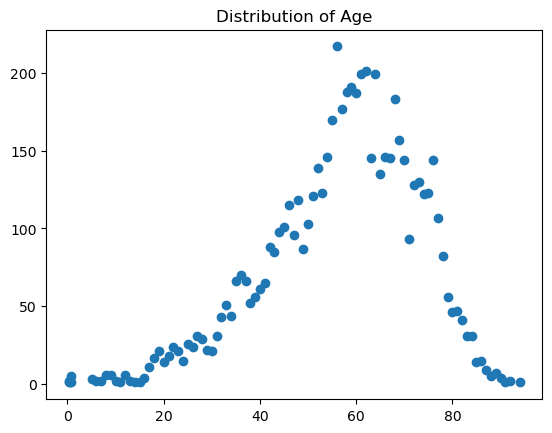

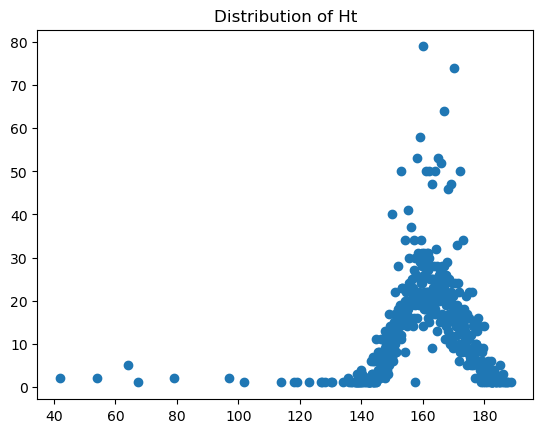

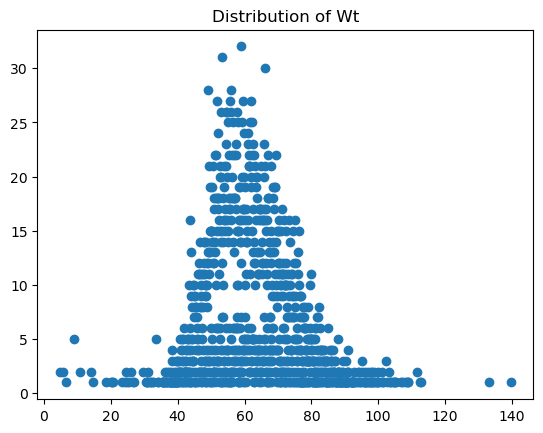

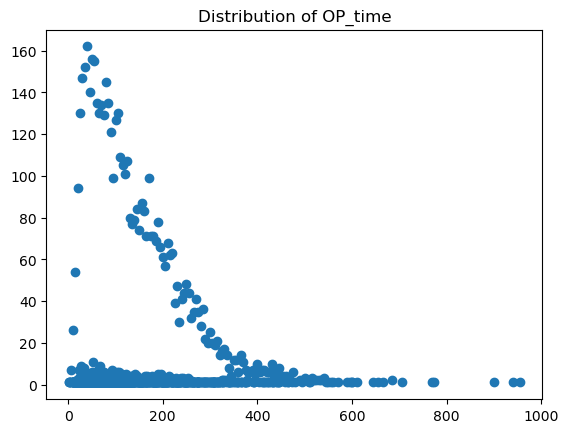

In [34]:
#for var in ['Age','Ht','Wt','OP_time']:
#    plt.figure()
#    if var == 'Ht':
#        plt.hist(info_new[var],bins=100)
#    else:
#        var_unique, counts = np.unique(info_new[var], return_counts=True)
#        plt.scatter(var_unique, counts)
#        if var == 'OR_time':
#            plt.xscale('log')
#    plt.title(f'Distribution of {var}')
#    plt.show()
    
    
for var in ['Age','Ht','Wt','OP_time']:
    plt.figure()
    var_unique, counts = np.unique(info_new[var], return_counts=True)
    plt.scatter(var_unique, counts)
    plt.title(f'Distribution of {var}')
    plt.show()

In [35]:
for var in ['Age','Ht','Wt','Sex','OP_time']:
    print(f'For variable {var}:')
    if var=='Sex':
        print(f'mode={stats.mode(info_new[var]).mode[0]}')
        print(f'class balance: {np.sum(info_new[var])} to {len(info_new)-np.sum(info_new[var])}\n')
    else:
        print(f'mean={np.mean(info_new[var])}')
        print(f'standard deviation={np.std(info_new[var])}\n')

For variable Age:
mean=57.2964934251722
standard deviation=14.975289087630397

For variable Ht:
mean=162.18883218534754
standard deviation=9.90455404392499

For variable Wt:
mean=61.48492172824045
standard deviation=11.944200387476362

For variable Sex:
mode=0
class balance: 3145 to 3243

For variable OP_time:
mean=135.98546232519305
standard deviation=101.15376625280656



/var/folders/v_/x9g5rqbn6rq7sdnq6dcr2zc80000gn/T/ipykernel_74457/1600276625.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print(f'mode={stats.mode(info_new[var]).mode[0]}')


<Axes: >

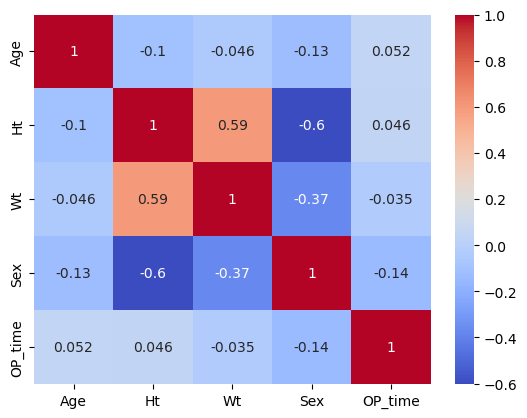

In [36]:
cor_mat = info_new[['Age','Ht','Wt','Sex','OP_time']].corr()
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)

# Outlier Detection

### Mahalanobis (we assume our data to be unimodal because all of our individual distributions were unimodal)

In [37]:
num_data = info_new[['Age','Ht','Wt','Sex','OP_time']]
mu = list(np.mean(num_data))
iv = np.linalg.inv(num_data.cov())

/Users/dylanmack/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [38]:
info_new['Mahalanobis'] = num_data.apply(lambda x: distance.mahalanobis(x,mu,iv),axis=1)

In [40]:
info_new.head()

,subjectid,Age,Ht,Wt,Sex,OP_time,Mahalanobis
0,5955,77.0,160.2,67.5,0,145.0,1.867660
1,2487,54.0,167.3,54.8,0,215.0,1.623615
2,2861,62.0,169.1,69.7,0,32.0,1.575830
3,1903,74.0,160.6,53.0,0,255.0,2.000307
4,4416,66.0,171.0,59.7,0,295.0,2.022579


In [41]:
# Remove data points with top 5% mahalanobis distance
thresh = np.quantile(list(info_new['Mahalanobis']),0.95)
data = info_new[info_new['Mahalanobis'] < thresh]
print(f'We removed {len(info_new[info_new["Mahalanobis"] >= thresh])} outliers, leaving {len(data)} points remaining')

We removed 320 outliers, leaving 6068 points remaining


<Axes: >

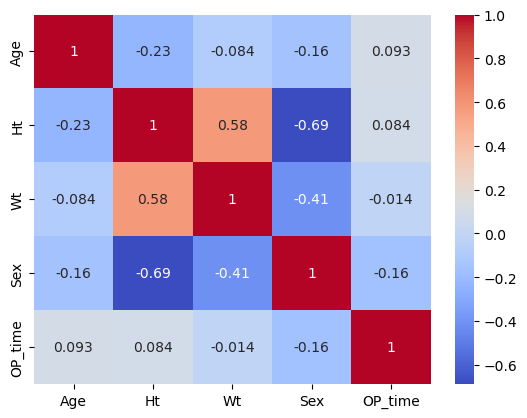

In [42]:
# evaluate change in correlation between height and age
cor_mat_new = data[['Age','Ht','Wt','Sex','OP_time']].corr()
sns.heatmap(cor_mat_new,cmap='coolwarm',annot=True)

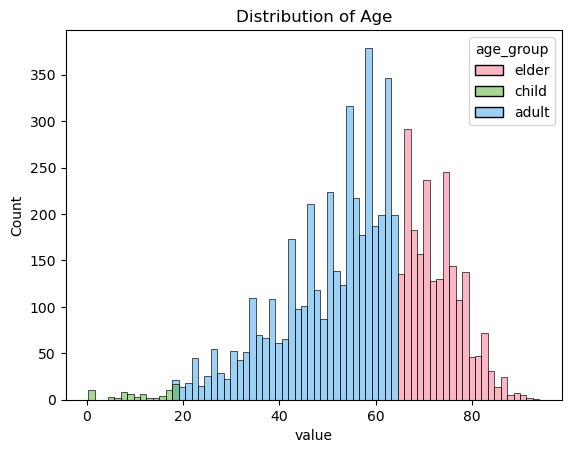

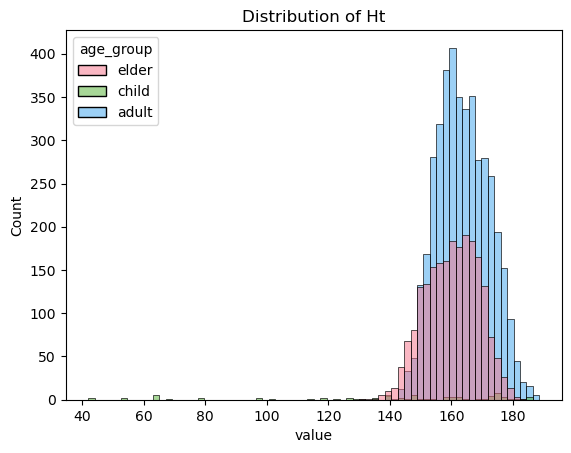

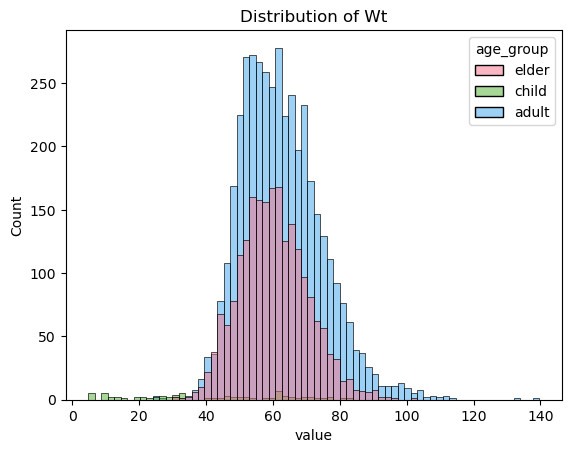

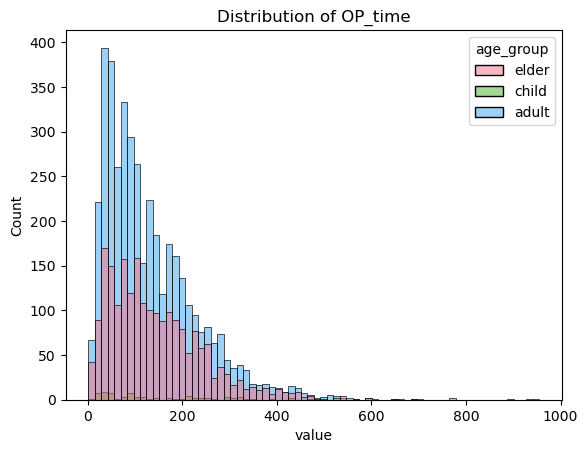

In [49]:
# Stratifying by age

info_new['age_group'] = info_new['Age'].apply(lambda x: 'child' if x < 19 else ('elder' if x > 64 else 'adult'))

for var in ['Age','Ht','Wt','OP_time']:
    to_plot = info_new.melt(id_vars='age_group', value_vars=var, var_name='variable', value_name='value')
    to_plot['age_group'] = pd.Categorical(to_plot['age_group'], categories=reversed(sorted(to_plot['age_group'].unique())), ordered=True)
    palette = sns.color_palette("husl", n_colors=len(to_plot['age_group'].unique()))

    plt.figure()
    sns.histplot(data=to_plot, x='value', hue='age_group', multiple='layer', bins=70, alpha=0.5, palette=palette)
    plt.title(f'Distribution of {var}')
    plt.show()

In [50]:
for var in ['Age','Ht','Wt','Sex','OP_time']:
    print(f'\nFor variable {var}:')
    for g in ['child','adult','elder']:
        print(f'In class {g},')
        if var=='Sex':
            print(f'mode={stats.mode(info_new[info_new["age_group"]==g][var]).mode[0]} (1=female,0=male)')
            print(f'class balance: {np.sum(info_new[info_new["age_group"]==g][var])} female to {len(info_new[info_new["age_group"]==g])-np.sum(info_new[info_new["age_group"]==g][var])} male\n')
        else:
            print(f'mean={np.mean(info_new[info_new["age_group"]==g][var])}')
            print(f'standard deviation={np.std(info_new[info_new["age_group"]==g][var])}\n')


For variable Age:
In class child,
mean=11.675675675675675
standard deviation=6.024809312016862

In class adult,
mean=50.184153661464585
standard deviation=10.888893800440727

In class elder,
mean=72.6519311307585
standard deviation=5.484172602364945


For variable Ht:
In class child,
mean=138.98918918918918
standard deviation=40.214057537966866

In class adult,
mean=163.63847779111646
standard deviation=8.383937382770846

In class elder,
mean=160.17812936249422
standard deviation=8.546384868097832


For variable Wt:
In class child,
mean=40.935810810810814
standard deviation=23.001716328837627

In class adult,
mean=62.55960864345739
standard deviation=12.106093865585798

In class elder,
mean=60.10966030711959
standard deviation=10.155852027793363


For variable Sex:
In class child,
mode=0 (1=female,0=male)
class balance: 36 female to 38 male

In class adult,
mode=1 (1=female,0=male)
class balance: 2241 female to 1924 male

In class elder,
mode=0 (1=female,0=male)
class balance: 868 fem

/var/folders/v_/x9g5rqbn6rq7sdnq6dcr2zc80000gn/T/ipykernel_74457/2844004311.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print(f'mode={stats.mode(info_new[info_new["age_group"]==g][var]).mode[0]} (1=female,0=male)')


In [52]:
data = pd.DataFrame()

for c in ['child','adult','elder']:
    small_data = info_new[info_new['age_group']==c].copy()
    num_data = small_data[['Age','Ht','Wt','Sex','OP_time']]
    mu = list(np.mean(num_data))
    iv = np.linalg.inv(num_data.cov())
    small_data['Mahalanobis'] = num_data.apply(lambda x: distance.mahalanobis(x,mu,iv),axis=1)
    thresh = np.quantile(list(small_data['Mahalanobis']),0.95)
    print(f'removing {len(small_data[small_data["Mahalanobis"] >= thresh])} outliers from {c} class')
    data = pd.concat([data, small_data[small_data['Mahalanobis'] < thresh]], ignore_index=True)

removing 4 outliers from child class
removing 209 outliers from adult class
removing 108 outliers from elder class


/Users/dylanmack/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **

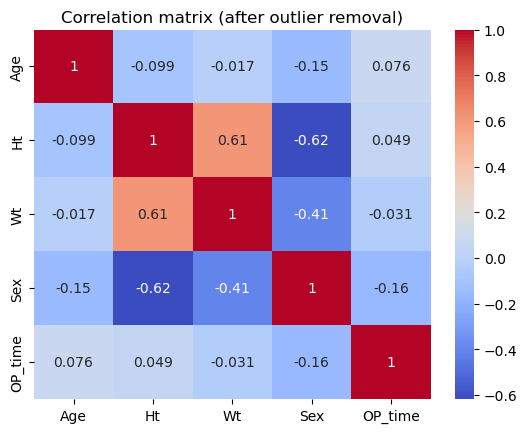

In [55]:
# WHY IS THIS ONE DIFFERENT THAN THE ONE ABOVE???
cor_mat_new = data[['Age','Ht','Wt','Sex','OP_time']].corr()
sns.heatmap(cor_mat_new,cmap='coolwarm',annot=True)
plt.title('Correlation matrix (after outlier removal)')
plt.show()

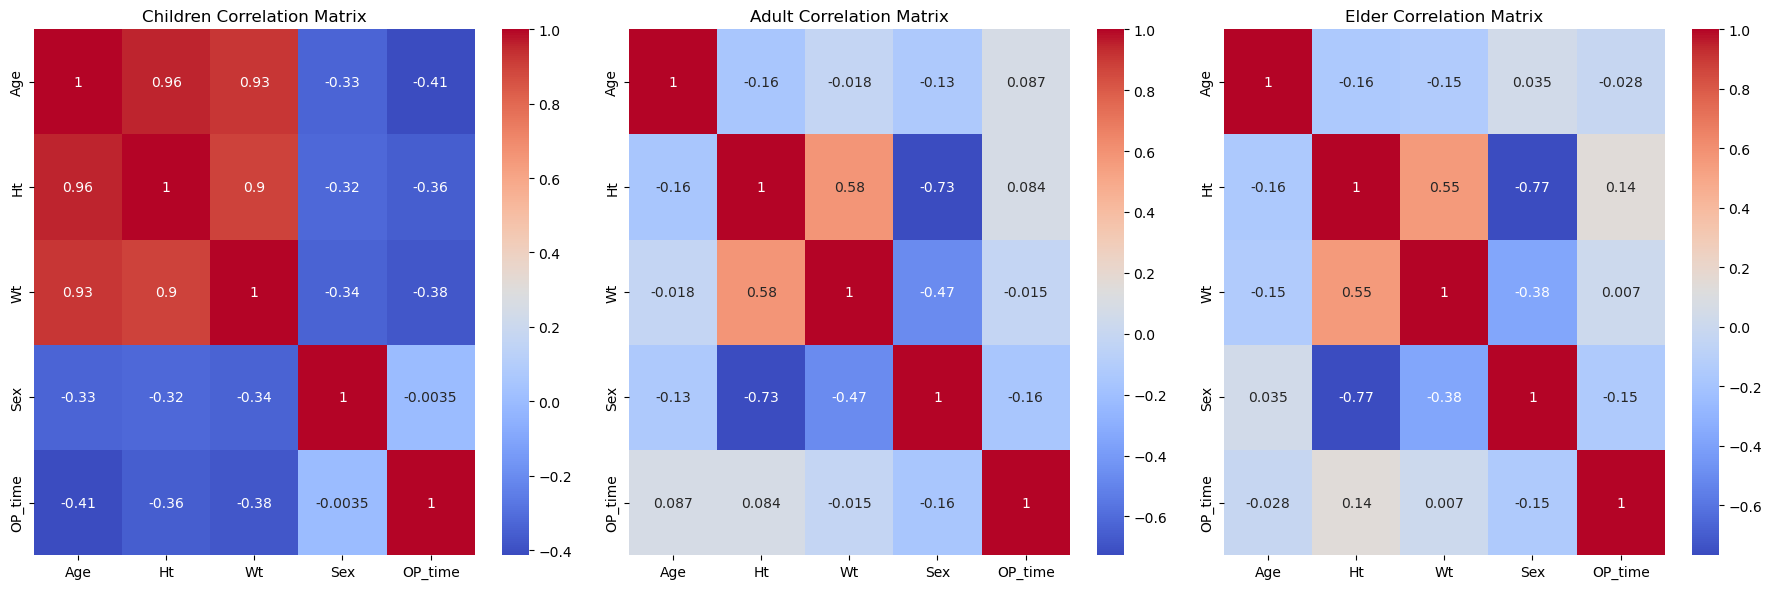

In [57]:
# Correlation matrix by Age class

cor_mat_children = data[data['age_group'] == 'child'][['Age','Ht','Wt','Sex','OP_time']].corr()
cor_mat_adults = data[data['age_group'] == 'adult'][['Age','Ht','Wt','Sex','OP_time']].corr()
cor_mat_elders = data[data['age_group'] == 'elder'][['Age','Ht','Wt','Sex','OP_time']].corr()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot heatmaps for each correlation matrix
sns.heatmap(cor_mat_children, ax=axs[0], cmap='coolwarm', annot=True)
sns.heatmap(cor_mat_adults, ax=axs[1], cmap='coolwarm', annot=True)
sns.heatmap(cor_mat_elders, ax=axs[2], cmap='coolwarm', annot=True)

# Set titles for each subplot
axs[0].set_title('Children Correlation Matrix')
axs[1].set_title('Adult Correlation Matrix')
axs[2].set_title('Elder Correlation Matrix')

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
